# A program to request and process USDA state-level corn data from the API server, and run a lowess filter to the logarithm. 

In [2]:
import requests
import pandas as pd
import numpy as np

import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams.update({'font.size': 24})

import seaborn as sns
sns.set()

In [76]:
state_alphas = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]

In [77]:
def tidy(df):
    del df["CV (%)"]
    del df["agg_level_desc"]
    del df["asd_desc"]
    del df["begin_code"]
    del df["class_desc"]
    del df["commodity_desc"]
    del df["congr_district_code"]
    del df["country_code"]
    del df["country_name"]
    del df["domain_desc"]
    del df["domaincat_desc"]
    del df["end_code"]
    del df["freq_desc"]
    del df["group_desc"]
    del df["load_time"]
    del df["location_desc"]
    del df["prodn_practice_desc"]
    del df["reference_period_desc"]
    del df["region_desc"]
    del df["sector_desc"]
    del df["short_desc"]
    del df["source_desc"]
    del df["statisticcat_desc"]
    del df["unit_desc"]
    del df["util_practice_desc"]
    del df["watershed_code"]
    del df["watershed_desc"]
    del df["week_ending"]
    del df["zip_5"]
    del df["county_ansi"]
    del df["state_ansi"]
    del df["asd_code"]
    del df["county_code"]
    del df["county_name"]
    
    return df

In [78]:
def get_corn(states, level):
    data = pd.DataFrame()
    for state in states:
        print("Now grabbing... " + state)
        dat = requests.get("http://quickstats.nass.usda.gov/api/api_GET/?key=210BA222-FC6E-3FB2-B4D7-DA2DAA1CC829&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=CORN&statisticcat_desc=YIELD&util_practice_desc=GRAIN&unit_desc=BU / ACRE&agg_level_desc=" + level + "&prodn_practice_desc=ALL PRODUCTION PRACTICES&reference_period_desc=YEAR&year__GE=1950&state_alpha="+state)
        if dat.status_code == 200:
            print("Data grabbed from USDA successfully...")
            dat = dat.json()
            dat = pd.DataFrame(dat["data"])
            data = pd.concat([data, dat], ignore_index = True)
            print("Filled!")
        else:
            print("Data grabbed from USDA unsuccessfully. Error code " + str(dat.status_code) + ". Skipping.")
    return tidy(data)

In [79]:
def get_corn_area(states, level):
    data = pd.DataFrame()
    for state in states:
        print("Now grabbing... " + state)
        dat = requests.get("http://quickstats.nass.usda.gov/api/api_GET/?key=210BA222-FC6E-3FB2-B4D7-DA2DAA1CC829&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=CORN&statisticcat_desc=AREA HARVESTED&util_practice_desc=GRAIN&unit_desc=ACRES&agg_level_desc=" + level + "&prodn_practice_desc=ALL PRODUCTION PRACTICES&reference_period_desc=YEAR&year__GE=1950&state_alpha="+state)
        if dat.status_code == 200:
            print("Data grabbed from USDA successfully...")
            dat = dat.json()
            dat = pd.DataFrame(dat["data"])
            data = pd.concat([data, dat], ignore_index = True)
            print("Filled!")
        else:
            print("Data grabbed from USDA unsuccessfully. Error code " + str(dat.status_code) + ". Skipping.")
    return tidy(data)

In [80]:
# Get corn yields
usda_state = get_corn(state_alphas, "STATE")

Now grabbing... AL
Data grabbed from USDA successfully...
Filled!
Now grabbing... AK
Data grabbed from USDA unsuccessfully. Error code 400. Skipping.
Now grabbing... AZ
Data grabbed from USDA successfully...
Filled!
Now grabbing... AR
Data grabbed from USDA successfully...
Filled!
Now grabbing... CA
Data grabbed from USDA successfully...
Filled!
Now grabbing... CO
Data grabbed from USDA successfully...
Filled!
Now grabbing... CT
Data grabbed from USDA successfully...
Filled!
Now grabbing... DE
Data grabbed from USDA successfully...
Filled!
Now grabbing... FL
Data grabbed from USDA successfully...
Filled!
Now grabbing... GA
Data grabbed from USDA successfully...
Filled!
Now grabbing... HI
Data grabbed from USDA unsuccessfully. Error code 400. Skipping.
Now grabbing... ID
Data grabbed from USDA successfully...
Filled!
Now grabbing... IL
Data grabbed from USDA successfully...
Filled!
Now grabbing... IN
Data grabbed from USDA successfully...
Filled!
Now grabbing... IA
Data grabbed from USD

In [146]:
# Get corn areas
usda_state_area = get_corn_area(state_alphas, "STATE")

Now grabbing... AL
Data grabbed from USDA successfully...
Filled!
Now grabbing... AK
Data grabbed from USDA unsuccessfully. Error code 400. Skipping.
Now grabbing... AZ
Data grabbed from USDA successfully...
Filled!
Now grabbing... AR
Data grabbed from USDA successfully...
Filled!
Now grabbing... CA
Data grabbed from USDA successfully...
Filled!
Now grabbing... CO
Data grabbed from USDA successfully...
Filled!
Now grabbing... CT
Data grabbed from USDA successfully...
Filled!
Now grabbing... DE
Data grabbed from USDA successfully...
Filled!
Now grabbing... FL
Data grabbed from USDA successfully...
Filled!
Now grabbing... GA
Data grabbed from USDA successfully...
Filled!
Now grabbing... HI
Data grabbed from USDA unsuccessfully. Error code 400. Skipping.
Now grabbing... ID
Data grabbed from USDA successfully...
Filled!
Now grabbing... IL
Data grabbed from USDA successfully...
Filled!
Now grabbing... IN
Data grabbed from USDA successfully...
Filled!
Now grabbing... IA
Data grabbed from USD

In [148]:
# Merge
usda_state_area = usda_state_area.rename(columns = {"Value": "Area"})
usda = pd.merge(usda_state, usda_state_area, on = ["state_alpha", "state_fips_code", "state_name", "year"], how = "inner")
usda.set_index(["state_name","state_alpha","state_fips_code","year"], inplace= True)
usda["Value"] = usda["Value"].astype(float)
usda["Area"] = usda["Area"].str.replace(",","").astype(float)

In [ ]:
# Add logs for lowess filter
usda["log_Value"] = np.log(usda["Value"])

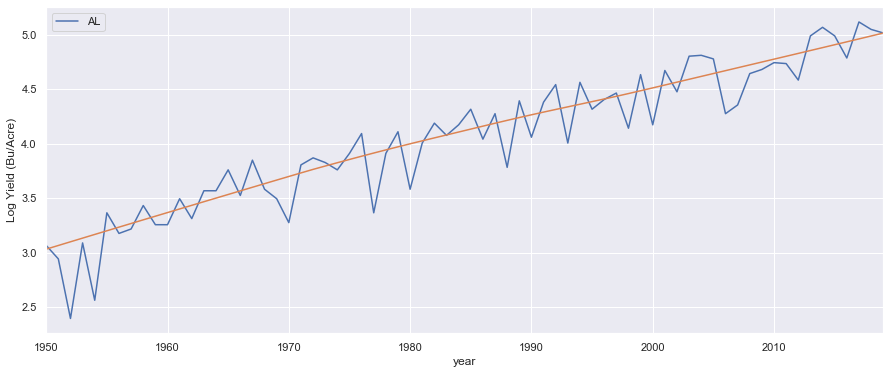

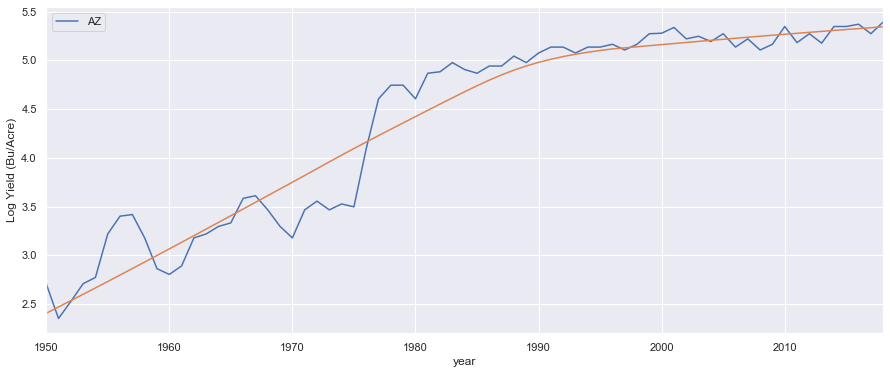

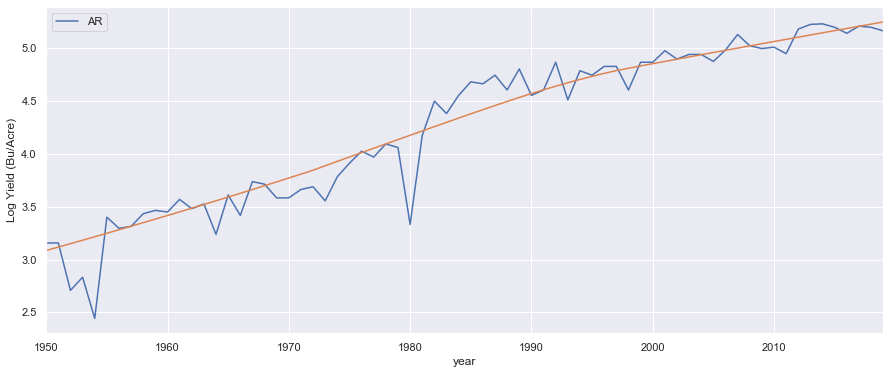

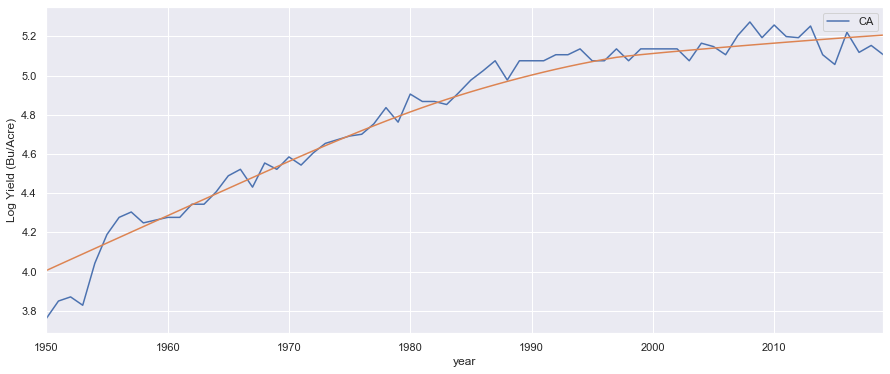

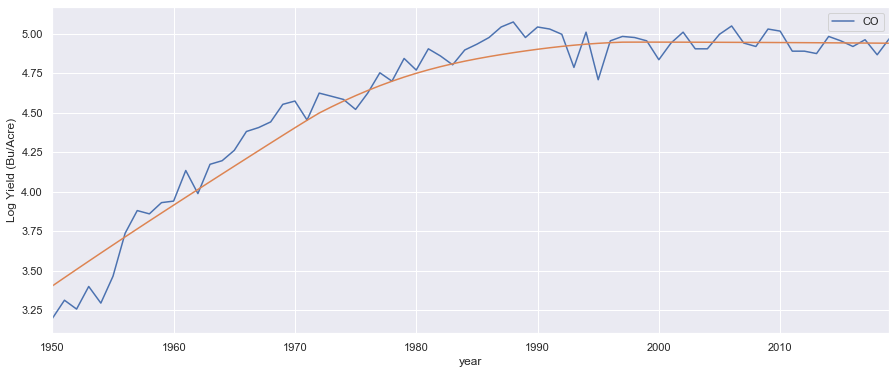

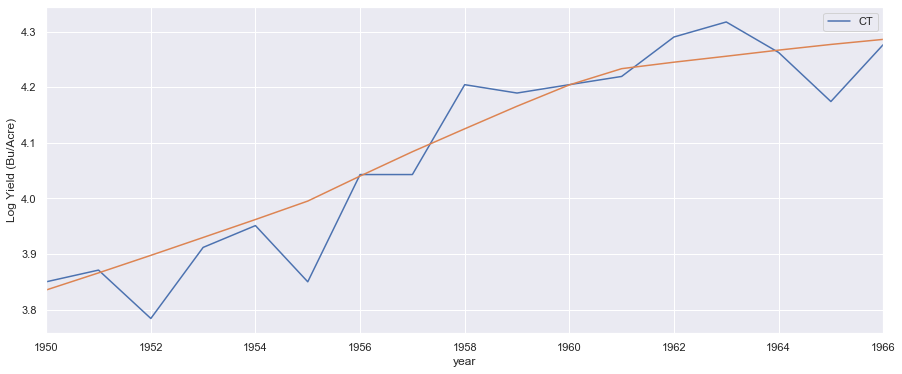

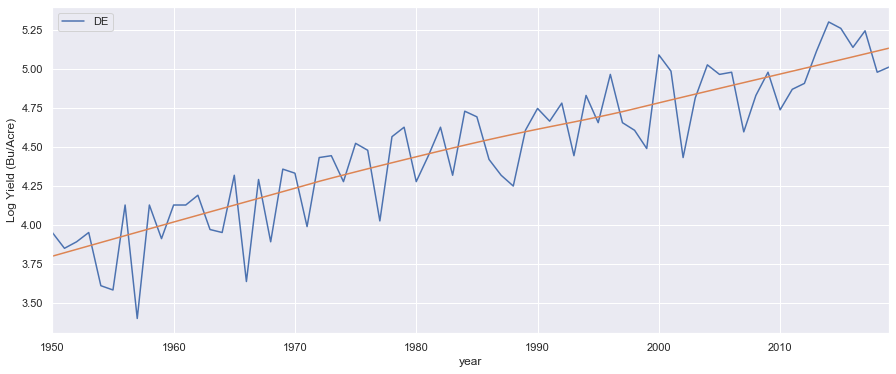

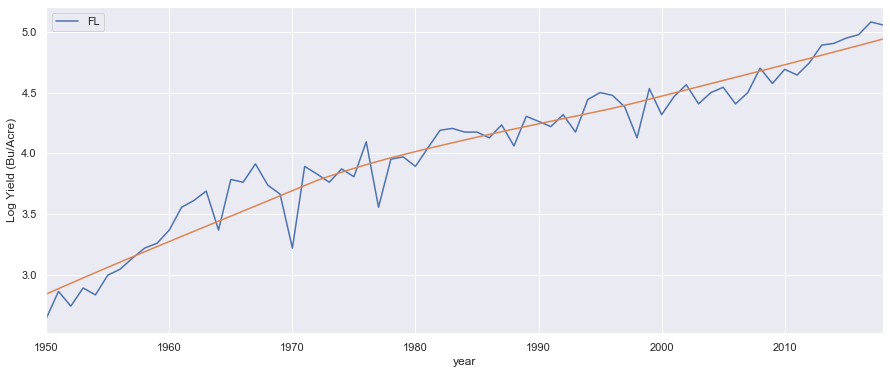

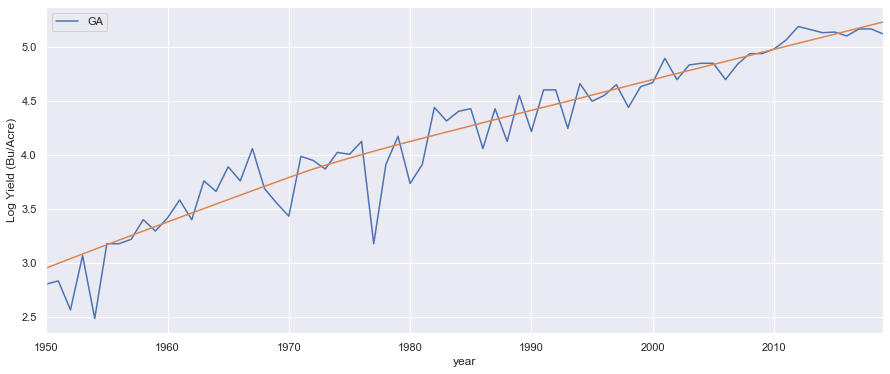

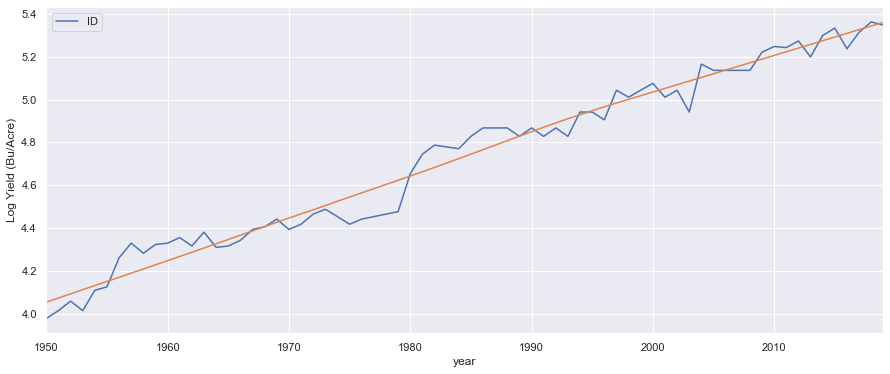

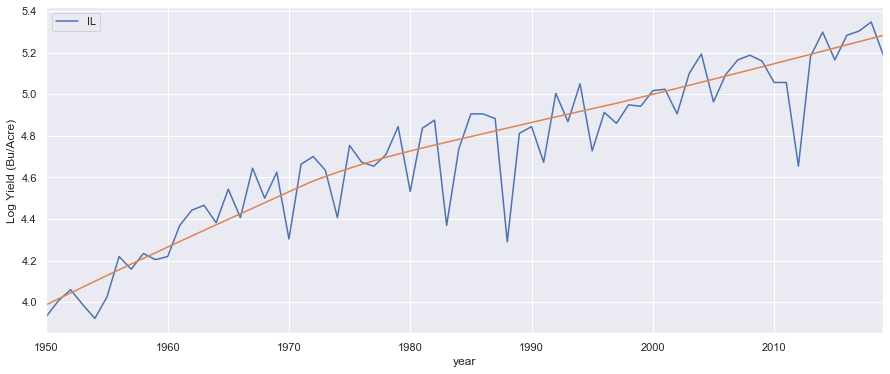

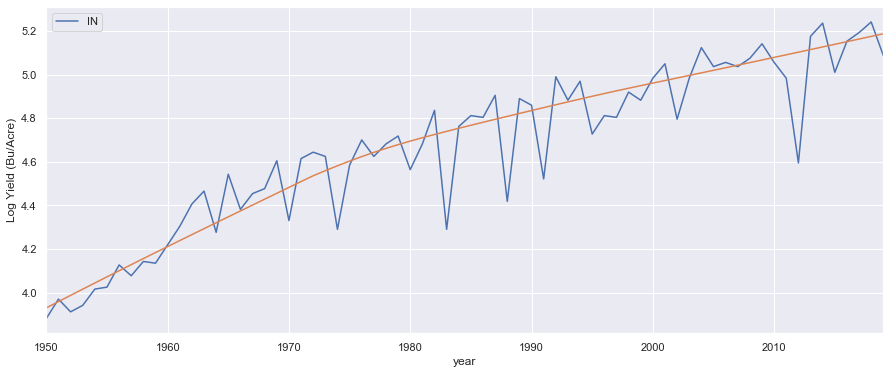

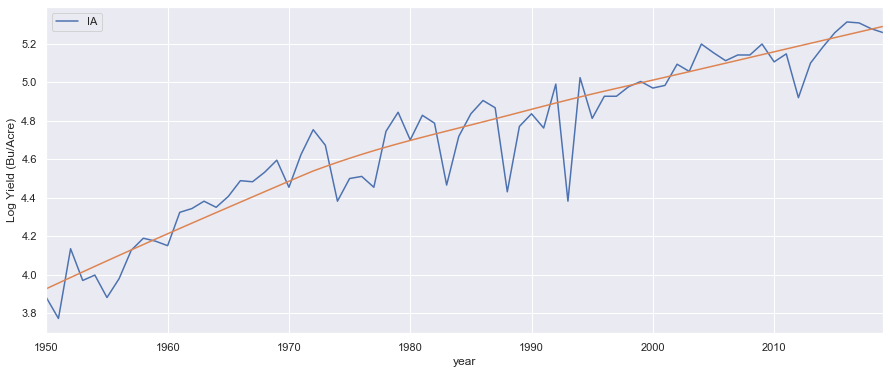

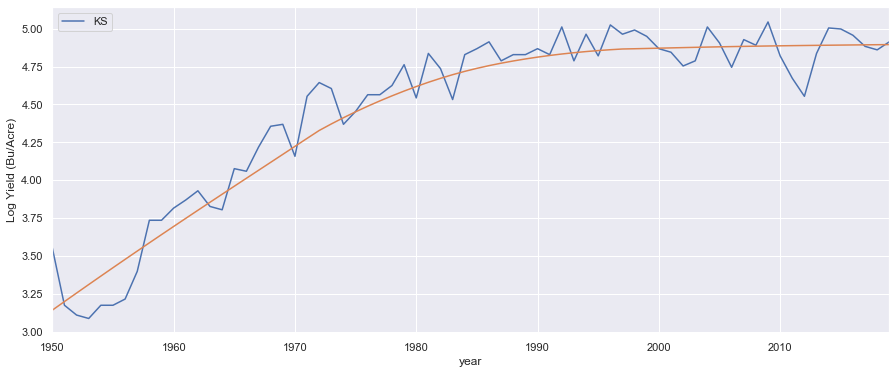

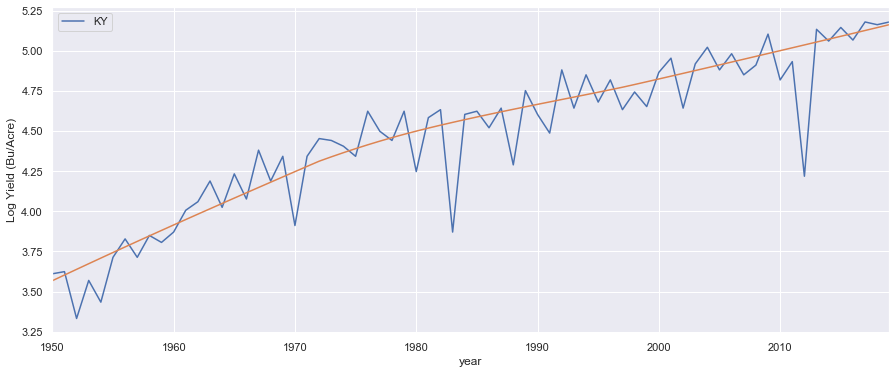

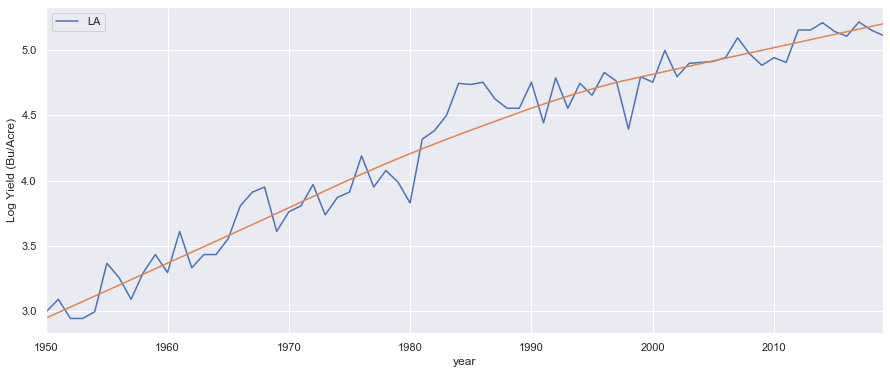

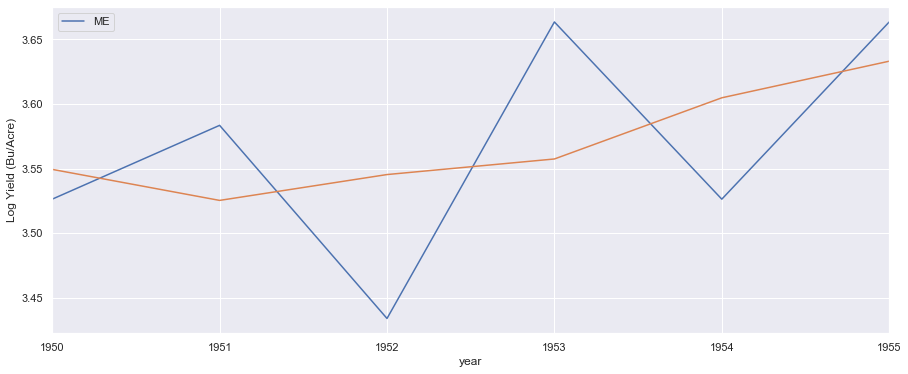

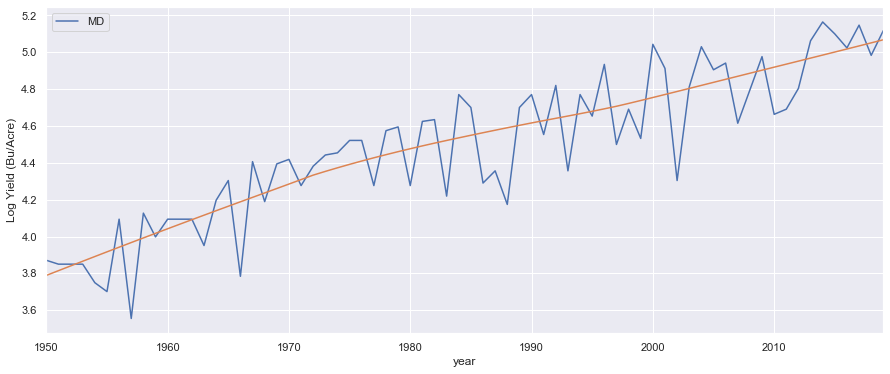

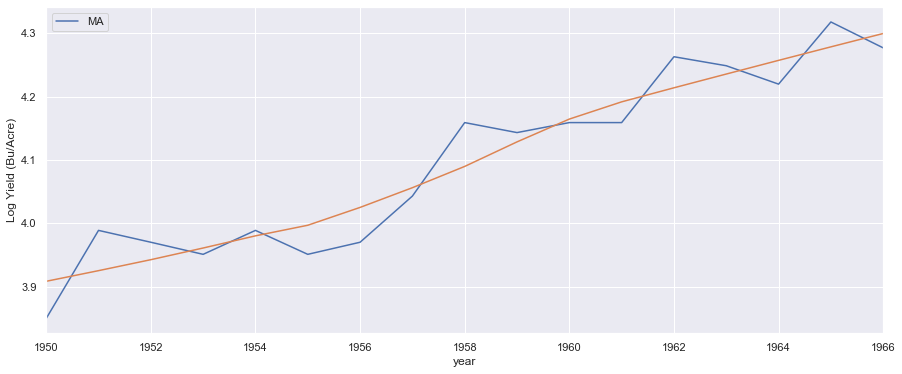

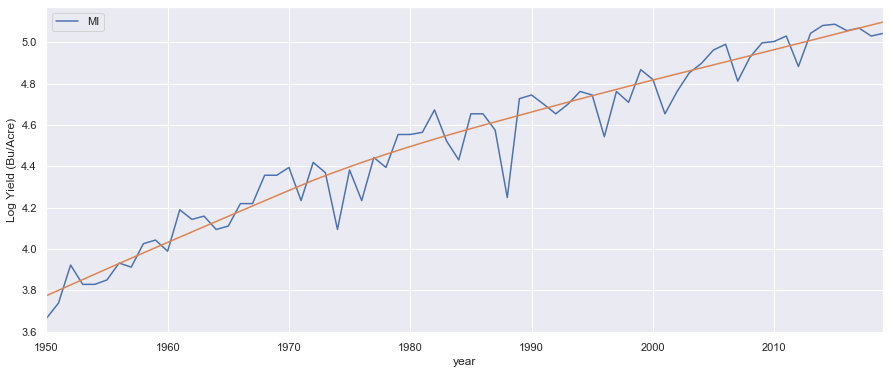

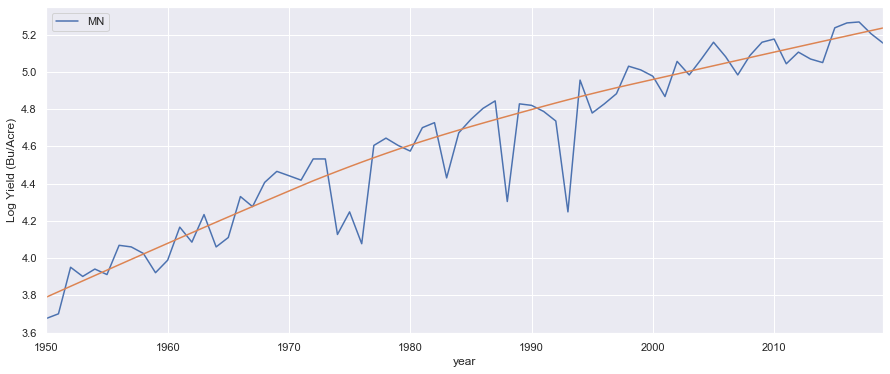

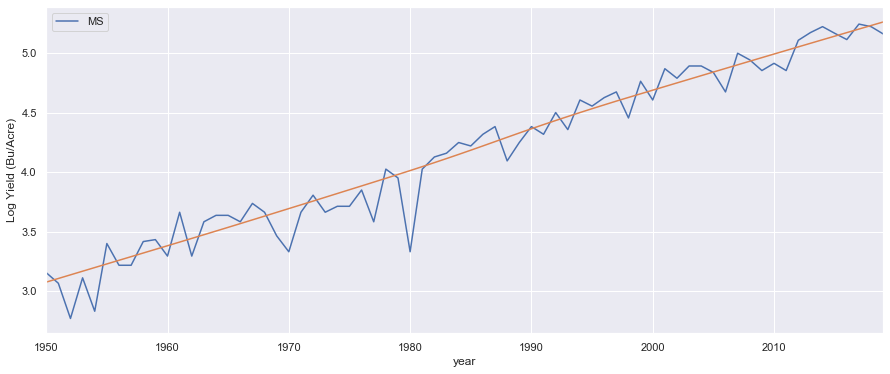

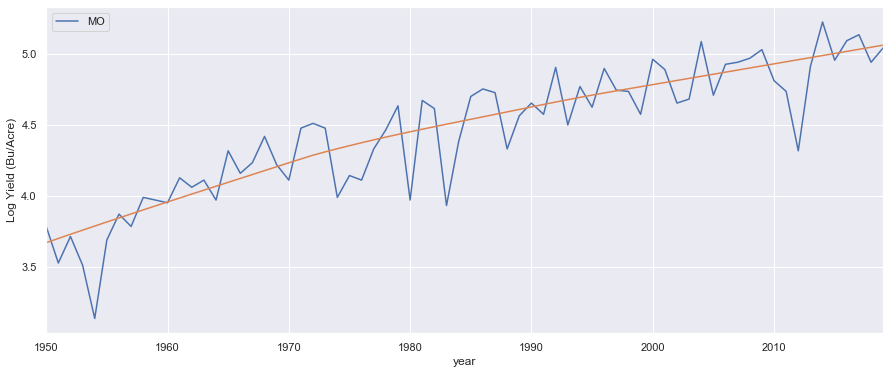

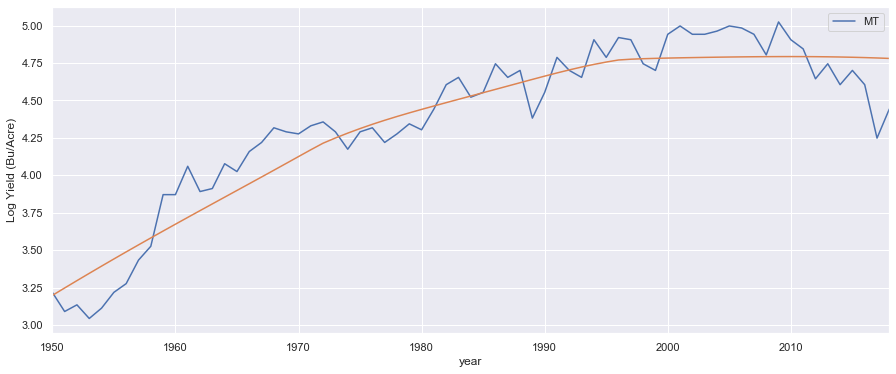

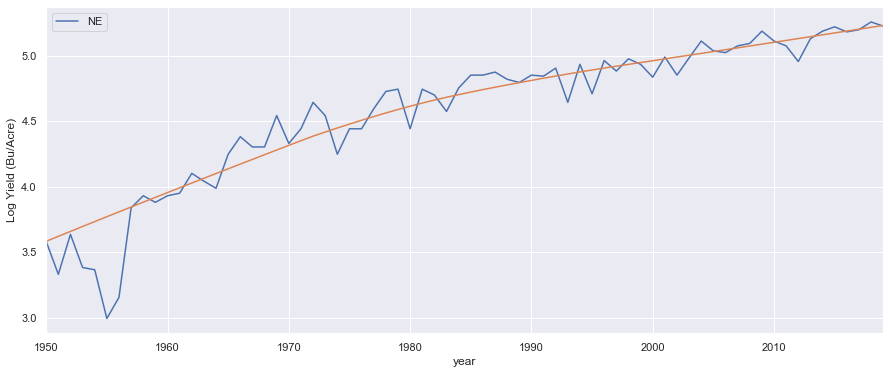

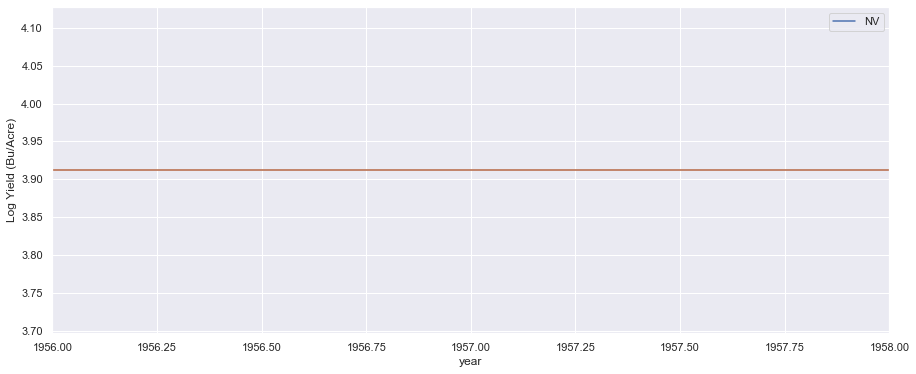

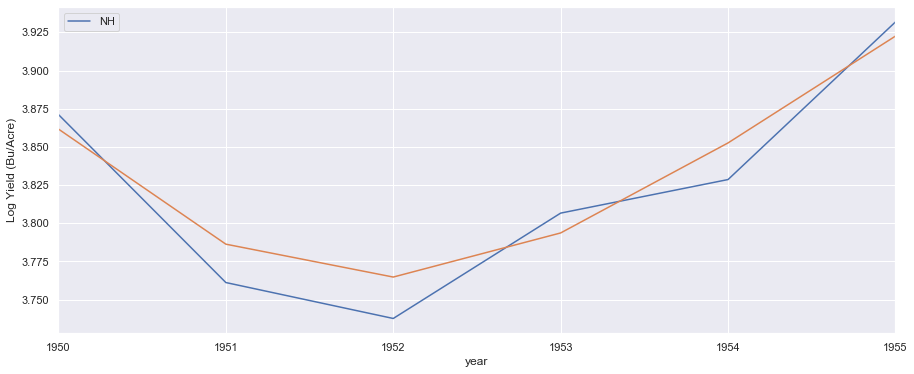

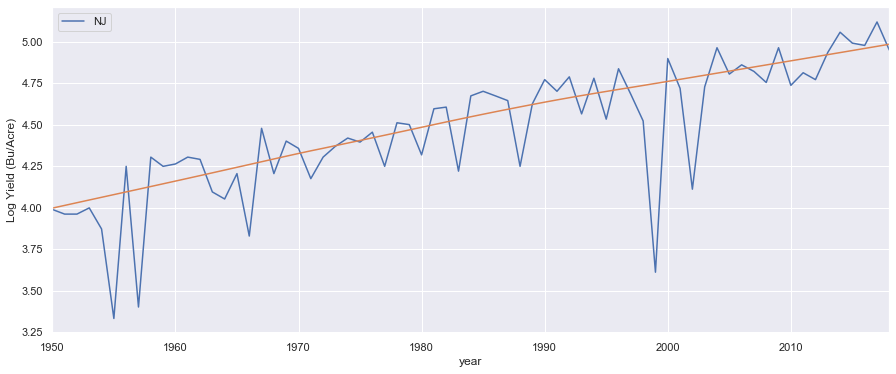

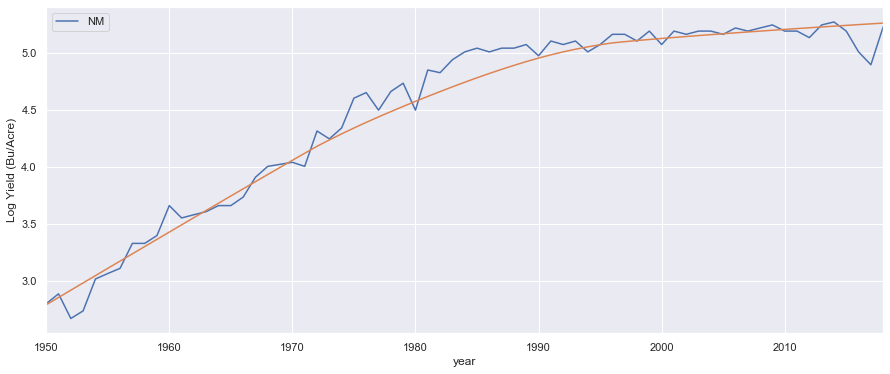

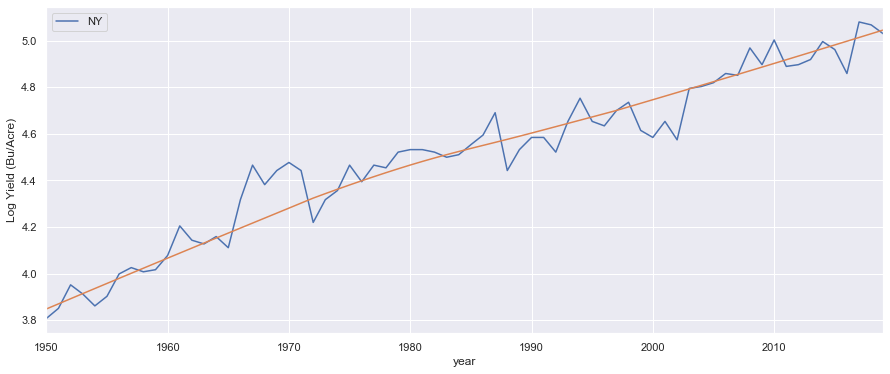

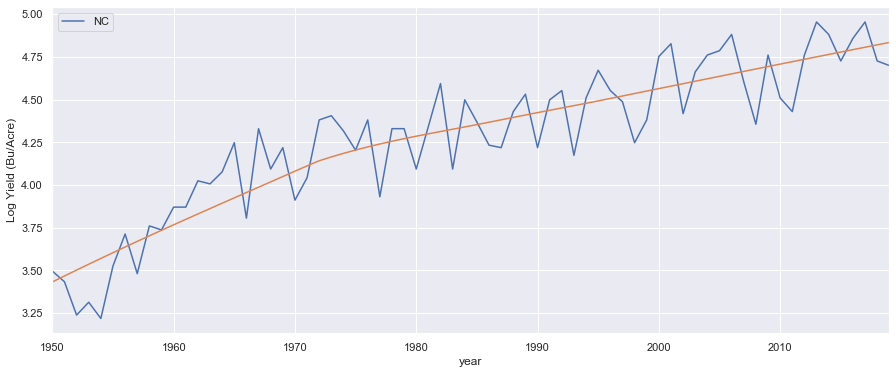

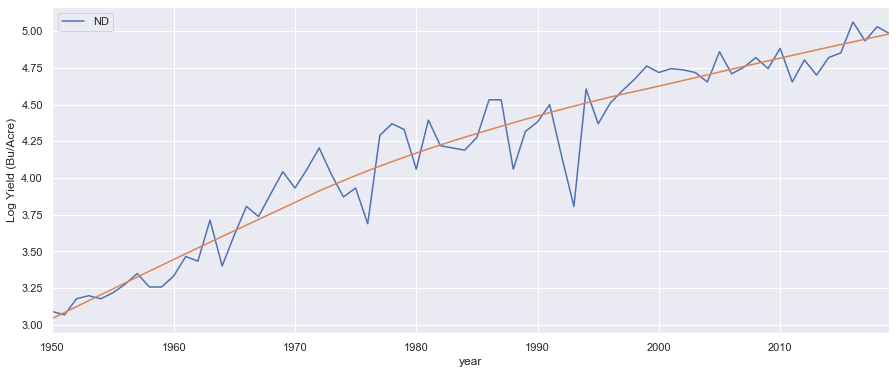

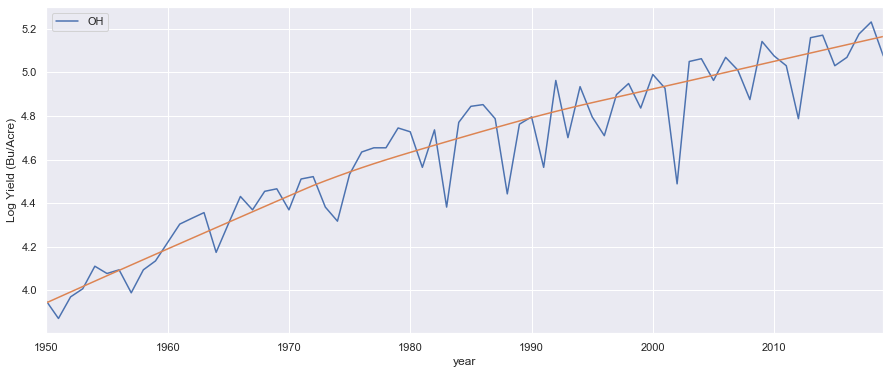

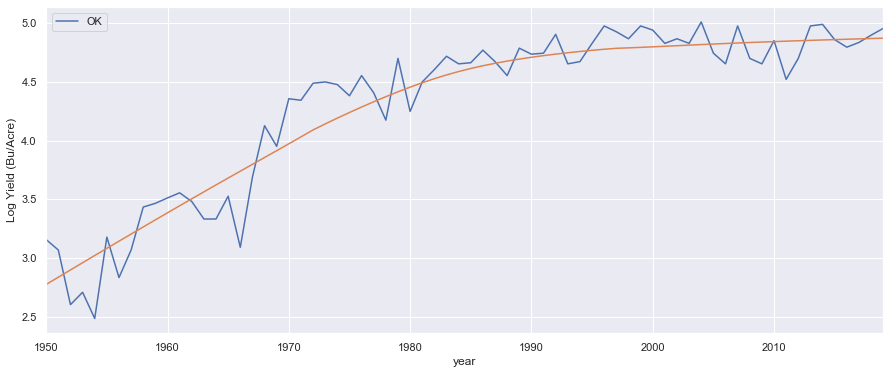

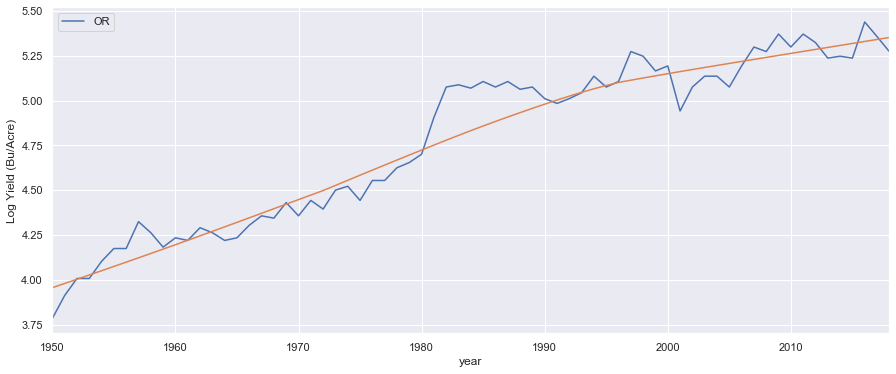

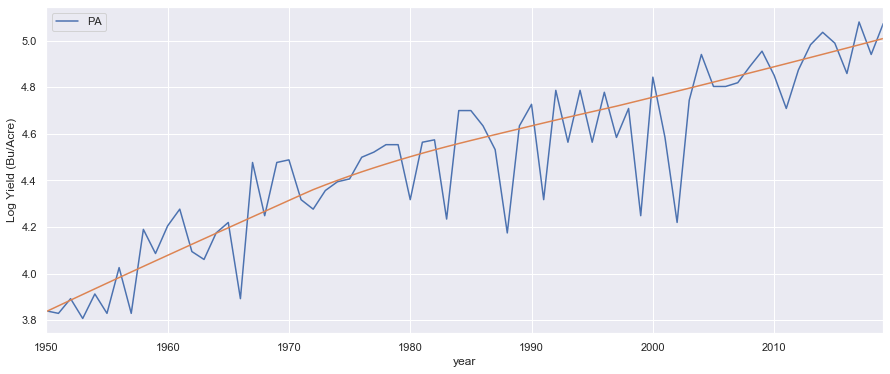

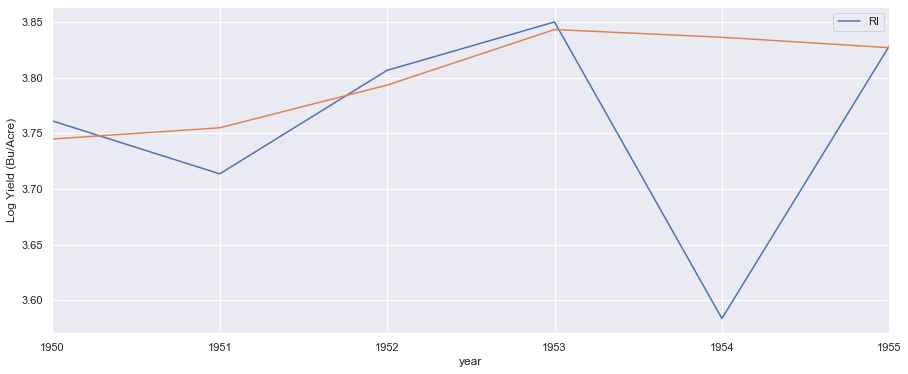

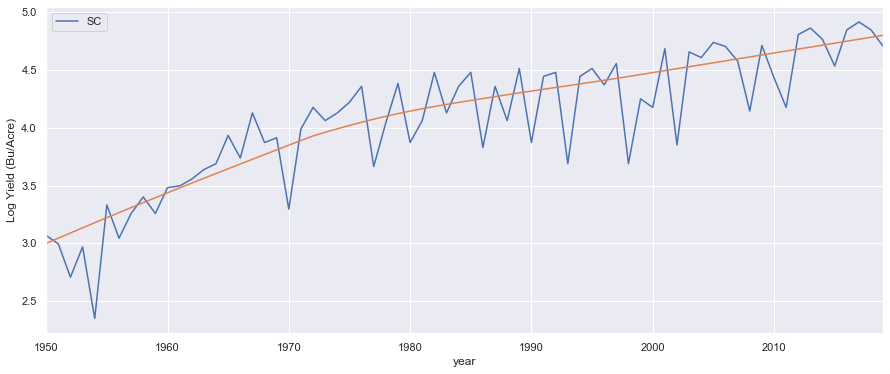

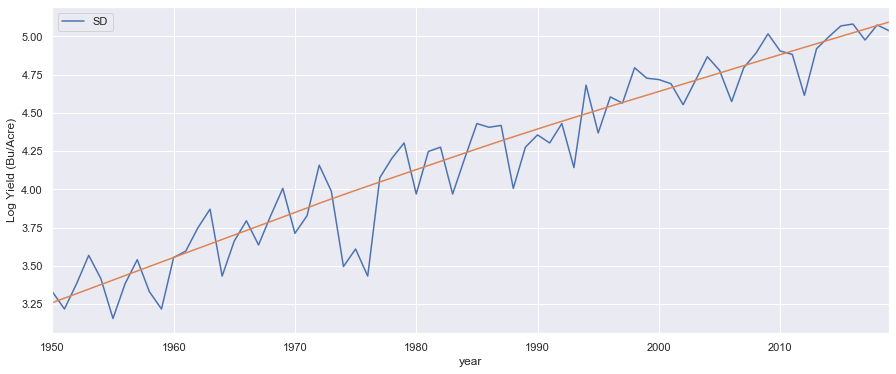

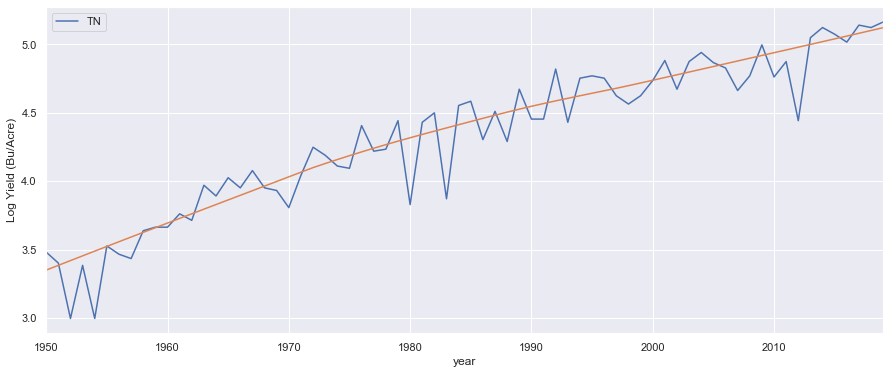

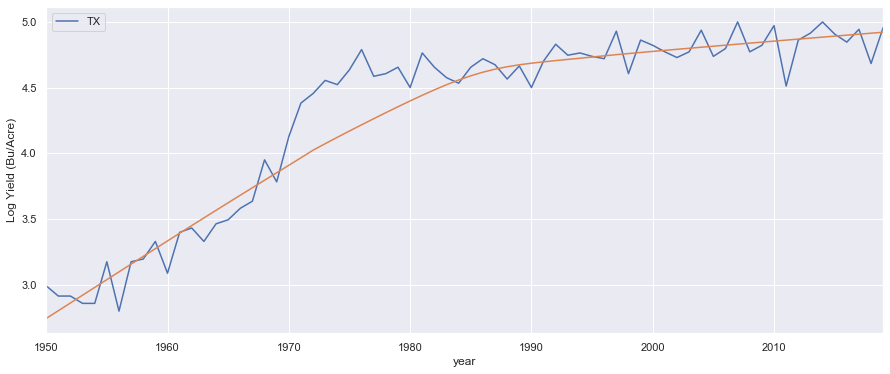

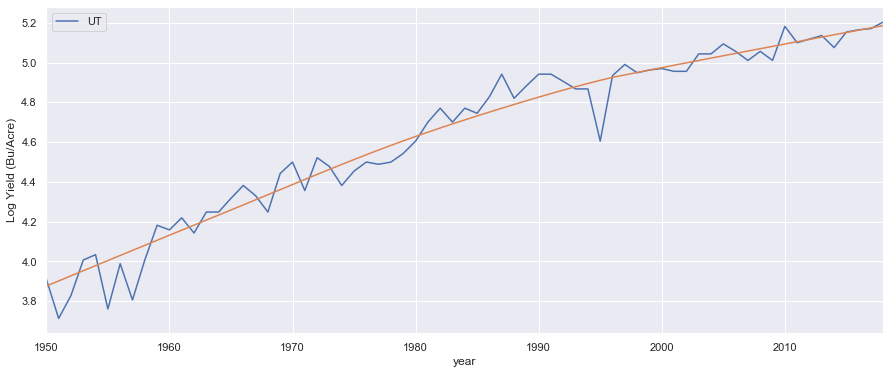

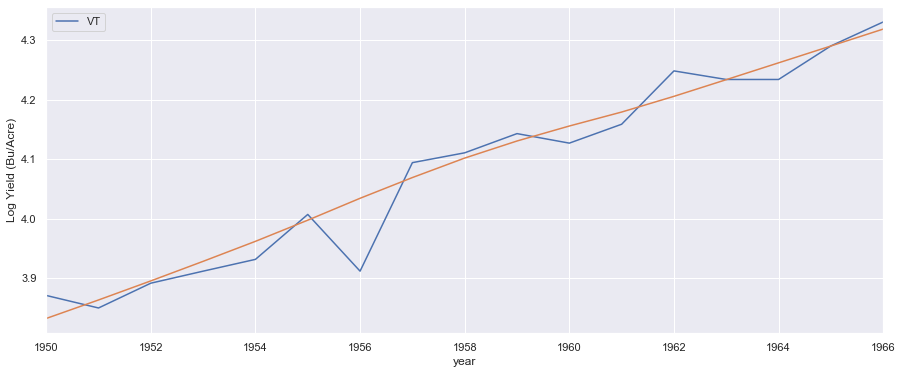

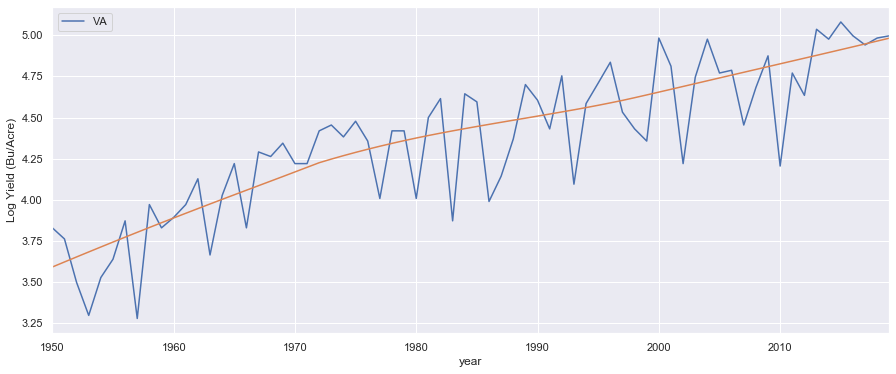

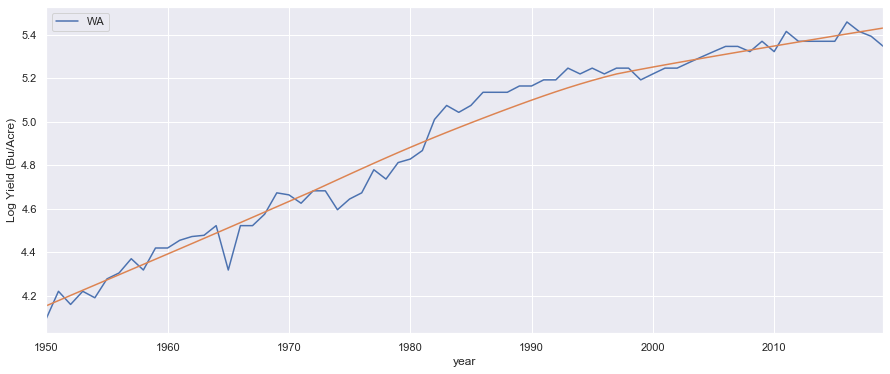

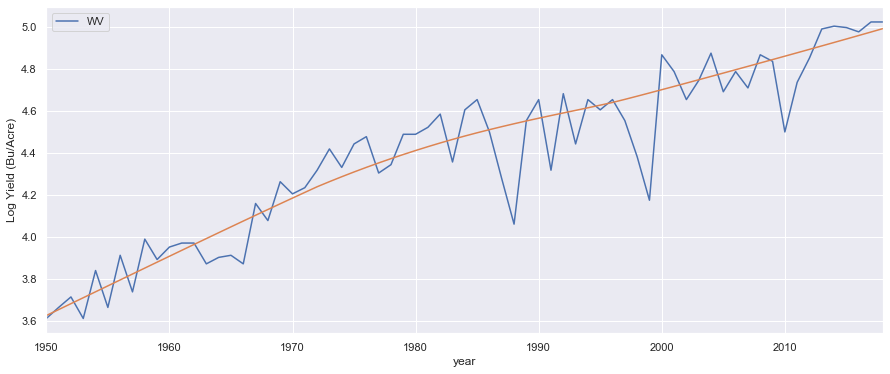

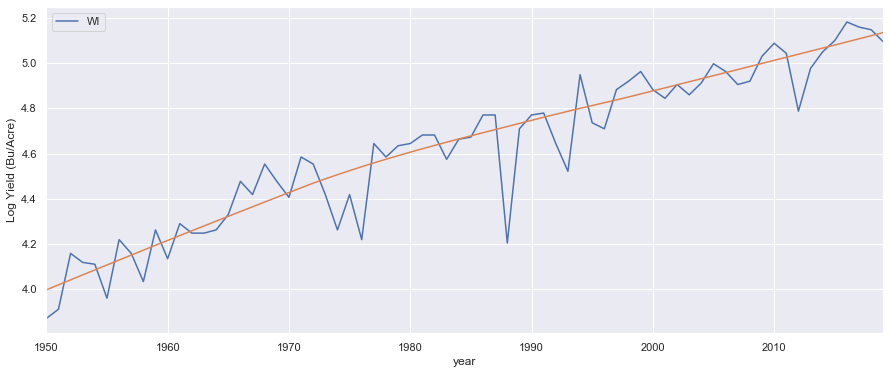

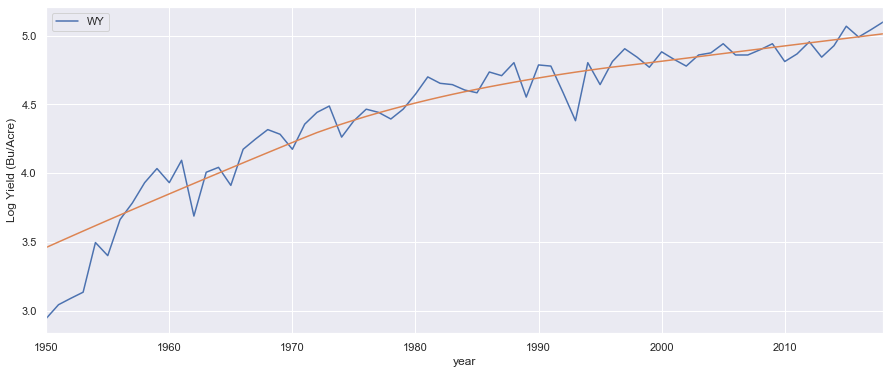

In [56]:
# Do lowess filter
lowess = sm.nonparametric.lowess
usda["lowess_log_Value"] = 0.0

usda = usda.reset_index()
usda.set_index(["state_alpha"], inplace= True)

for state in usda.index.unique(level = "state_alpha"):
    fig, ax = plt.subplots(figsize = (15,6))
    ax.set_ylabel("Log Yield (Bu/Acre)")
    ax.set_xlabel("Year")
    
    data = usda.loc[state]

    data.plot(x = "year", y = "log_Value", legend = True, label = state, ax = ax)
    
    lws_filter = lowess(data["log_Value"], data["year"], missing = "drop")
    ax.plot(lws_filter[:,0], lws_filter[:,1])
    
    temp = pd.DataFrame(data = {"lowess_log_Value_x" : pd.Series(lws_filter[:,1], index = pd.MultiIndex.from_arrays([[state]*len(lws_filter[:,0].astype(int)), lws_filter[:,0].astype(int)]))})
    temp.index.names = ["state_alpha", "year"]
    usda = pd.merge(usda, temp, on = ["state_alpha", "year"], how = "outer")
    usda = usda.fillna(0)
    usda["lowess_log_Value"] = usda["lowess_log_Value"] + usda["lowess_log_Value_x"]
    del usda["lowess_log_Value_x"]
    
    plt.show()

In [66]:
del usda["log_Diff"]

In [67]:
usda.head()

,state_name,state_fips_code,year,Value,Area,log_Value,lowess_log_Value
state_alpha,,,,,,,
AL,ALABAMA,1,2019,151.0,305000.0,5.017280,5.016102
AL,ALABAMA,1,2018,156.0,250000.0,5.049856,4.989243
AL,ALABAMA,1,2017,167.0,235000.0,5.117994,4.962462
AL,ALABAMA,1,2016,120.0,315000.0,4.787492,4.935760
AL,ALABAMA,1,2015,147.0,245000.0,4.990433,4.909131


In [68]:
# Save
del usda["state_name"]
usda.to_csv("./output/USDA_state_yields.csv")

In [9]:
usda = pd.read_csv('./output/USDA_state_yields.csv')

In [10]:
usda.set_index('state_alpha', inplace = True)

In [13]:
state_alphas = usda.index.unique(level = "state_alpha")

In [14]:
state_alphas

Index(['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 'IL', 'IN',
       'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT',
       'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA',
       'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'],
      dtype='object', name='state_alpha')

In [12]:
usda.head()

,state_fips_code,year,Value,Area,log_Value,lowess_log_Value
state_alpha,,,,,,
AL,1,2019,151.0,305000.0,5.017280,5.016102
AL,1,2018,156.0,250000.0,5.049856,4.989243
AL,1,2017,167.0,235000.0,5.117994,4.962462
AL,1,2016,120.0,315000.0,4.787492,4.935760
AL,1,2015,147.0,245000.0,4.990433,4.909131


In [17]:
# Do quadratic fit
usda['quad_fit'] = 0.0

for state in state_alphas:

    data = usda.loc[state]
    
    if type(data["Value"]) != np.float64:
        z = np.polyfit(data['year'], data['log_Value'], 2)
        p = np.poly1d(z)
    
        tempQ = pd.DataFrame(data = {"quad_fit_x" : pd.Series(p(data['year']), index = pd.MultiIndex.from_arrays([[state]*len(data['year'].astype(int)), data['year'].astype(int)]))})
        tempQ.index.names = ["state_alpha", "year"]
        usda = pd.merge(usda, tempQ, on = ["state_alpha", "year"], how = "outer")
        usda = usda.fillna(0)
        usda["quad_fit"] = usda["quad_fit"] + usda["quad_fit_x"]
        del usda["quad_fit_x"]

In [18]:
usda

,state_fips_code,year,Value,Area,log_Value,lowess_log_Value,quad_fit
state_alpha,,,,,,,
AL,1,2019,151.0,305000.0,5.017280,5.016102,4.955380
AL,1,2018,156.0,250000.0,5.049856,4.989243,4.934763
AL,1,2017,167.0,235000.0,5.117994,4.962462,4.913890
AL,1,2016,120.0,315000.0,4.787492,4.935760,4.892759
AL,1,2015,147.0,245000.0,4.990433,4.909131,4.871372
...,...,...,...,...,...,...,...
WY,56,1954,33.0,7000.0,3.496508,3.619058,3.477343
WY,56,1953,23.0,7000.0,3.135494,3.579786,3.423232
WY,56,1952,22.0,11000.0,3.091042,3.540275,3.368124


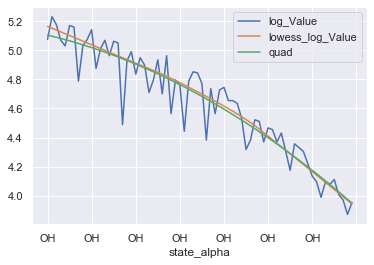

In [22]:
usda.loc['OH']['log_Value'].plot()
usda.loc['OH']['lowess_log_Value'].plot()
usda.loc['OH']['quad_fit'].plot(label = 'quad')
plt.legend()

In [23]:
usda.to_csv("./output/USDA_state_yields.csv")